In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score,balanced_accuracy_score

import umap

/volatile/ad279118/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#! pip install umap-learn

In [3]:
np.random.seed(51)

#### Display options

In [4]:
pd.set_option('display.max_row', 25)
pd.set_option('display.max_column', 25)

##### Load the embeddings representations for the ACCP (which is the training dataset) and the HCP dataset (which will be the input for the trained SVM classifier)

In [5]:
#embeddings_ACCP= pd.read_csv("/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Output/2024-05-13/09-33-29_206/acc_epoch60_embeddings/full_embeddings.csv")#, index_col=0)
#embeddings_ACCP= pd.read_csv("/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Output/2024-05-17/17-33-50_137/ACCP_epoch60_embeddings/full_embeddings.csv")
embeddings_ACCP= pd.read_csv("/neurospin/dico/adufournet/mycode/Output/CINGULATE_left/09-35-58_201/acc_train_test_embeddings/full_embeddings.csv")
embeddings_ACCP.shape

(341, 257)

In [6]:
labels_ACCP = pd.read_csv("/neurospin/dico/data/deep_folding/current/datasets/ACCpatterns/subjects_labels.csv")
labels_ACCP = labels_ACCP[['long_name','Left_PCS']]


In [7]:
def encoder(df, col):
    code = {'present':1,
            'absent':0}
    df[col] = df[col].map(code)
    return df

encoder(labels_ACCP,'Left_PCS') 

,long_name,Left_PCS
0,nih_chp_04701_t1,1
1,nih_chp_01534_t1,1
2,nih_chp_04623_t1,1
3,nih_chp_01503_t1,0
4,nih_chp_00404_t1,1
...,...,...
376,a0005_t1_s03,0
377,a0006_t1_s03,1
378,a0001_t1_s03,1
379,a0016_t1_s03,0


In [8]:
embeddings_HCP = pd.read_csv("/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Output/2024-05-13/09-33-29_206/hcp_epoch60_embeddings/full_embeddings.csv", index_col=0)
#embeddings_HCP = pd.read_csv("/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Output/2024-05-17/17-33-50_137/HCP_epoch60_embeddings/full_embeddings.csv", index_col=0)
embeddings_HCP.head()

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,...,dim245,dim246,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
ID,,,,,,,,,,,,,,,,,,,,,,,,,
100206,-5.876003,-0.845744,-12.204170,10.151408,-18.957836,-29.795780,12.937123,-7.214358,15.110987,10.792451,-7.787244,9.263735,...,7.441906,6.935698,-15.116919,33.840183,-19.154482,12.863470,-20.392763,-25.990793,4.171558,-21.955696,-0.573337,-4.697568
100307,-19.529308,-7.768003,-16.622694,15.692203,-32.981106,-20.219995,-20.074820,3.648118,4.962884,28.067015,7.735142,13.419550,...,8.451640,-9.411729,-2.882752,35.724358,-11.517761,25.840712,-23.715145,-31.383976,7.298614,-4.549547,22.780191,-29.140709
100408,-24.607979,2.905064,-9.724290,35.772090,-38.557724,5.821410,-11.363668,18.840570,-9.526131,34.880870,-6.178275,-7.339914,...,11.223726,6.418972,5.701094,47.347880,-1.811345,-25.851000,2.173108,10.323122,-16.164135,32.424270,-1.851322,15.037244
100610,-8.027011,0.322856,-15.113009,3.927100,-22.753002,-6.738647,10.846553,47.801365,18.840824,19.917740,-4.696721,-15.373317,...,-10.238463,13.516448,-4.859896,60.652016,10.704345,-9.717216,-4.234411,-0.872676,-14.263339,-9.549306,8.477722,4.729099
101006,-25.976790,-5.441645,-10.610805,-9.526792,14.037749,-4.063296,12.062643,-15.676752,12.239485,5.389635,8.132303,-29.955600,...,-26.664420,20.419096,-7.835833,56.926426,6.239031,-7.533917,2.079582,8.960461,12.988546,-5.051035,25.262693,-14.783053


#### Load the UKBiobank embedded space to fit the scaler for the ACCP and HCP data 

In [9]:
#embeddings_UKB = pd.read_csv("/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Output/2024-05-13/09-33-29_206/UKB_epoch60_embeddings/full_embeddings.csv", index_col=0)
#embeddings_UKB = pd.read_csv("/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Output/2024-05-17/17-33-50_137/UKB_epoch60_embeddings/full_embeddings.csv", index_col=0)
embeddings_UKB = pd.read_csv("/neurospin/dico/adufournet/mycode/Output/CINGULATE_left/09-35-58_201/UKB40_trained_on_WBA_embeddings/full_embeddings.csv", index_col=0)
embeddings_UKB.head()

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,...,dim245,dim246,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
ID,,,,,,,,,,,,,,,,,,,,,,,,,
sub-1000021,-17.120142,1.622911,29.612385,-40.696520,24.235834,-20.847820,-3.118726,28.908573,55.370453,10.790565,7.921936,-1.683447,...,18.992370,11.613450,52.652370,4.786344,-28.442580,5.625811,-24.886963,-13.790014,57.153954,0.391331,7.860309,-10.623850
sub-1000325,-9.878295,-1.404222,-4.839814,-9.111913,6.749300,-5.316842,4.766978,41.121680,42.754360,1.393050,-8.377953,0.201570,...,17.645071,-6.560491,3.657555,-14.262843,-1.340518,-20.501827,14.720462,19.704353,79.013725,25.066990,-4.136014,-31.512993
sub-1000458,0.155924,-1.701078,-1.037222,3.497135,0.774527,-4.002703,-8.362634,24.631160,52.584120,-4.306631,-7.962847,-12.094856,...,-14.199136,-30.040209,20.042908,-1.661914,-10.601421,-22.001625,-17.279018,-7.617548,73.344790,7.961368,9.491467,3.684893
sub-1000575,0.858536,26.205385,4.035416,31.739508,-1.471139,-4.223968,0.584004,0.648601,38.738297,-42.401455,-5.997243,-8.631557,...,-7.192543,-50.375435,-8.499899,-1.015408,-28.953450,-11.896119,0.926740,9.155063,89.167010,-9.850862,-8.097056,18.132452
sub-1000606,9.236704,34.216167,-14.650463,-2.831459,31.528416,-15.401288,3.403423,28.977566,-5.812005,-0.625146,-10.184343,0.271640,...,12.561330,-8.799233,17.502953,22.935211,-8.765962,-16.930529,1.715147,-0.353538,118.942280,6.498045,3.230927,-2.804252


#### Scaler

In [10]:
ebdd_lbl_ACCP = embeddings_ACCP.set_index('ID').join(labels_ACCP.set_index('long_name'))
X = ebdd_lbl_ACCP.drop('Left_PCS', axis=1)
y = ebdd_lbl_ACCP['Left_PCS']

The scaler is fited on the UKB database at first, it transforms it and then transforms the HCP dataset.
Is it better to fit on everything and transform everything at once ?

In [11]:
use_scaler = False

if use_scaler:
    scaler = StandardScaler()
    scaler.fit(embeddings_UKB)
    X = scaler.transform(X)
    bdd_hcp = scaler.transform(embeddings_HCP)
    bdd_ukb = scaler.transform(embeddings_UKB)
else:
    bdd_hcp = embeddings_HCP
    bdd_ukb = embeddings_UKB

print(X.shape ,bdd_hcp.shape)

(341, 256) (1114, 256)


**Quelle représentation ?**

/volatile/ad279118/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


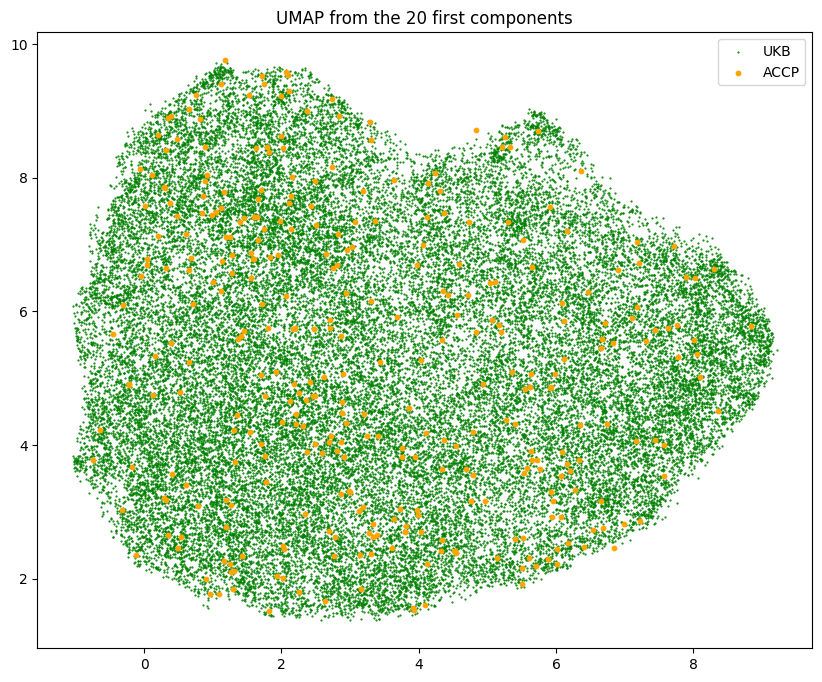

In [12]:
umap_reducer = umap.UMAP()#random_state=5)

umap_reducer.fit(bdd_ukb)
embedding2D_ukb = umap_reducer.transform(bdd_ukb)
embedding2D_troiani = umap_reducer.transform(X)

plt.figure(figsize=(10,8))
plt.scatter(embedding2D_ukb[:,0], embedding2D_ukb[:,1], c='g', s=0.3, label='UKB')
plt.scatter(embedding2D_troiani[:,0], embedding2D_troiani[:,1], c='orange', s=10, label='ACCP')
plt.title('UMAP from the 20 first components')
plt.legend()
plt.show()

#### SVC model, trained on the ACCP database

In [13]:
model = SVC(kernel='linear', probability=True,
            random_state=42,
            C=0.01, class_weight='balanced', decision_function_shape='ovr')

model_train_test = SVC(kernel='linear', probability=True,
            random_state=42,
            C=0.01, class_weight='balanced', decision_function_shape='ovr')

Specific stratification for a more relevant auc.

In [14]:
train_val_path = '/neurospin/dico/data/deep_folding/current/datasets/ACCpatterns/ACCpatterns_subjects_train_val.csv'
test_path = '/neurospin/dico/data/deep_folding/current/datasets/ACCpatterns/ACCpatterns_subjects_test.csv'

ACC_train_val = pd.read_csv(train_val_path, header=None)
ACC_test = pd.read_csv(test_path, header=None)

X_train = (ebdd_lbl_ACCP.loc[ACC_train_val[0]]).drop('Left_PCS', axis=1)
y_train = (ebdd_lbl_ACCP.loc[ACC_train_val[0]])['Left_PCS']
    

X_test = (ebdd_lbl_ACCP.loc[ACC_test[0]]).drop('Left_PCS', axis=1)
y_test = (ebdd_lbl_ACCP.loc[ACC_test[0]])['Left_PCS']

if use_scaler:
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
model_train_test.fit(X_train, y_train)
roc_auc_score(y_test,model_train_test.predict_proba(X_test)[:,1]), balanced_accuracy_score(y_test, model_train_test.predict(X_test))

(np.float64(0.796401515151515), np.float64(0.6950757575757576))

Cross validation to have another auc (which is supposed to be worse than with the stratification) 

In [15]:
outputs = {}
val_pred = cross_val_predict(model, X, y, cv=5)
auc = roc_auc_score(y, val_pred)
outputs['labels_pred'] = val_pred
outputs['auc'] = auc
outputs['balanced_accuracy_score'] = balanced_accuracy_score(y, val_pred)

In [16]:
outputs['auc'], outputs['balanced_accuracy_score']

(np.float64(0.7582090097996197), np.float64(0.7582090097996197))

The auc value below is not relevant because we are training the model on the whole set so as to test the model on the whole set.

In [17]:
model.fit(X,y)
roc_auc_score(y,model.predict_proba(X)[:,1]), balanced_accuracy_score(y, model.predict(X))

(np.float64(0.9394105601872166), np.float64(0.880539710399298))

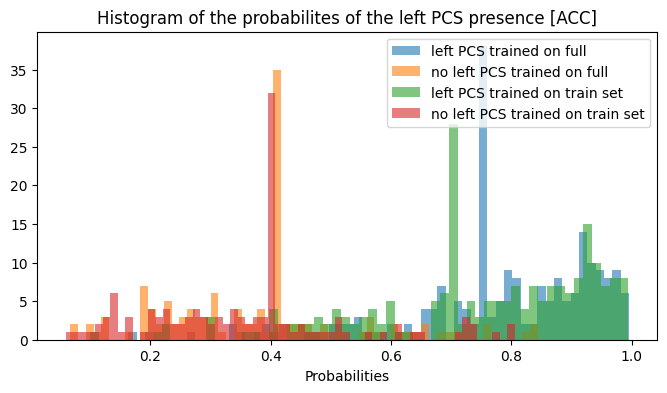

In [18]:
plt.figure(figsize=(8,4))
plt.hist(model.predict_proba(X)[y==1,1], bins=60, alpha=0.6, label='left PCS trained on full')
plt.hist(model.predict_proba(X)[y==0,1], bins=60, alpha=0.6, label='no left PCS trained on full')
plt.hist(model_train_test.predict_proba(X)[y==1,1], bins=60, alpha=0.6, label='left PCS trained on train set')
plt.hist(model_train_test.predict_proba(X)[y==0,1], bins=60, alpha=0.6, label='no left PCS trained on train set')
plt.xlabel('Probabilities')
plt.title('Histogram of the probabilites of the left PCS presence [ACC]')
plt.legend()
plt.show()

In [19]:
float((model.predict(X) == (model.predict_proba(X)>0.5)[:,1]).sum())/len(X)

0.9501466275659824

#### Classification of the HCP embeddings

In [20]:
val_pred = model.predict(X=bdd_hcp)


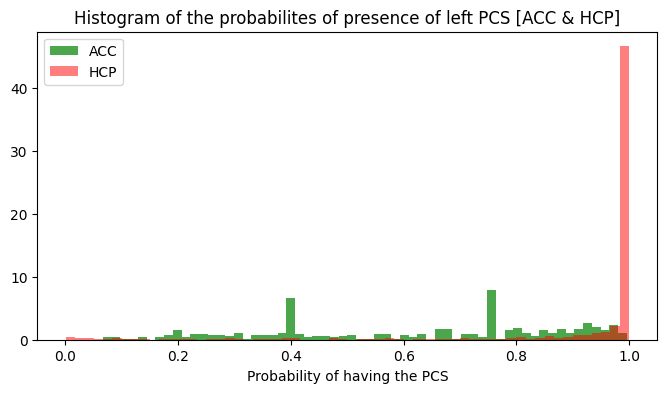

In [21]:
plt.figure(figsize=(8,4))
plt.hist(model.predict_proba(X)[:,1], bins=60, color='g', alpha=0.7, label='ACC', density=True)
plt.hist(model.predict_proba(bdd_hcp)[:,1], bins=60, color='red', alpha=0.5, label='HCP', density=True)
plt.xlabel('Probability of having the PCS')
plt.title('Histogram of the probabilites of presence of left PCS [ACC & HCP]')
plt.legend()
plt.show()

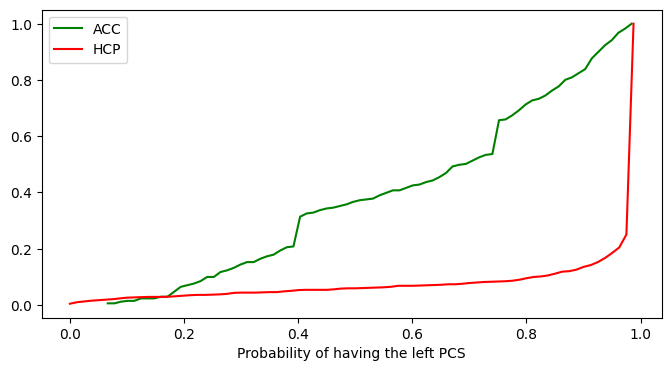

In [22]:
values_ACCP, base_ACCP = np.histogram(model.predict_proba(X)[:,1], bins=80)
cumulative_ACCP = np.cumsum(values_ACCP)

values_HCP, base_HCP = np.histogram(model.predict_proba(bdd_hcp)[:,1], bins=80)

cumulative_HCP = np.cumsum(values_HCP)
plt.figure(figsize=(8,4))
plt.plot(base_ACCP[:-1], cumulative_ACCP/len(X), c='g', label='ACC')
if use_scaler:
    plt.plot(base_HCP[:-1], cumulative_HCP/len(bdd_hcp), c='r', label='HCP')
else:
    plt.plot(base_HCP[:-1], cumulative_HCP/len(embeddings_HCP), c='r', label='HCP')
plt.xlabel('Probability of having the left PCS')
plt.legend()
plt.show()

#### SVM classification between ACCP and HCP datasets

In [23]:
scd_bdd_hcp = pd.DataFrame(bdd_hcp, columns=embeddings_HCP.columns)
scd_bdd_hcp['Dataset'] = 0

scd_bdd_ACCP = pd.DataFrame(X,columns=embeddings_HCP.columns)
scd_bdd_ACCP['Dataset'] = 1

In [24]:
scd_bdd_HCP_ACCP = pd.concat([scd_bdd_hcp,scd_bdd_ACCP], axis=0)
scd_bdd_HCP_ACCP

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,...,dim246,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256,Dataset
ID,,,,,,,,,,,,,,,,,,,,,,,,,
100206,-5.876003,-0.845744,-12.204170,10.151408,-18.957836,-29.795780,12.937123,-7.214358,15.110987,10.792451,-7.787244,9.263735,...,6.935698,-15.116919,33.840183,-19.154482,12.863470,-20.392763,-25.990793,4.171558,-21.955696,-0.573337,-4.697568,0
100307,-19.529308,-7.768003,-16.622694,15.692203,-32.981106,-20.219995,-20.074820,3.648118,4.962884,28.067015,7.735142,13.419550,...,-9.411729,-2.882752,35.724358,-11.517761,25.840712,-23.715145,-31.383976,7.298614,-4.549547,22.780191,-29.140709,0
100408,-24.607979,2.905064,-9.724290,35.772090,-38.557724,5.821410,-11.363668,18.840570,-9.526131,34.880870,-6.178275,-7.339914,...,6.418972,5.701094,47.347880,-1.811345,-25.851000,2.173108,10.323122,-16.164135,32.424270,-1.851322,15.037244,0
100610,-8.027011,0.322856,-15.113009,3.927100,-22.753002,-6.738647,10.846553,47.801365,18.840824,19.917740,-4.696721,-15.373317,...,13.516448,-4.859896,60.652016,10.704345,-9.717216,-4.234411,-0.872676,-14.263339,-9.549306,8.477722,4.729099,0
101006,-25.976790,-5.441645,-10.610805,-9.526792,14.037749,-4.063296,12.062643,-15.676752,12.239485,5.389635,8.132303,-29.955600,...,20.419096,-7.835833,56.926426,6.239031,-7.533917,2.079582,8.960461,12.988546,-5.051035,25.262693,-14.783053,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-inhibition25_ses-pretraining_T1w,21.999397,-0.121602,-13.400997,-17.156400,15.936625,-9.599301,3.674234,31.208618,21.735535,-13.427456,-8.623571,-9.608850,...,-15.900776,-19.191936,-18.936077,-11.605991,-36.149162,-2.337486,8.895266,67.893776,17.297039,-27.509449,-26.968336,1
sub-inhibition26_ses-pretraining_T1w,2.937505,17.925688,3.506663,11.606631,6.779515,-0.089334,-0.722748,-5.777012,37.017357,-10.381082,7.863040,-1.484549,...,-24.930983,-10.194620,-16.933765,-28.653786,13.804318,-3.898741,22.638727,81.322010,15.483537,0.333755,10.744370,1
sub-inhibition28_ses-pretraining_T1w,1.042227,12.055752,16.936445,4.590945,-6.695252,-0.768160,14.897638,11.188953,41.158318,-2.533640,10.020423,-2.032718,...,-9.916248,22.295920,8.893103,-12.703056,-23.473642,3.414270,17.337723,91.873405,0.306444,2.946689,4.897506,1


In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(scd_bdd_HCP_ACCP.drop("Dataset", axis=1), scd_bdd_HCP_ACCP["Dataset"], test_size=0.01, random_state=40)

In [27]:
model2 = SVC(kernel='linear', probability=True,
            random_state=42,
            C=0.01, class_weight='balanced', decision_function_shape='ovr')

In [28]:
model2.fit(X_train,y_train)
val_predict = cross_val_predict(model2, X_train, y_train, cv=10)
auc = roc_auc_score(y_train, val_predict)
auc

np.float64(1.0)

In [29]:
roc_auc_score(y_test, model2.predict_proba(X_test)[:,1])

np.float64(1.0)

### Classification of the UKB dataset

In [37]:
path_to_save = "/volatile/ad279118/Imaging_Genetics_2025/Figures_Report/Paracingulate"

In [38]:
val_pred = model.predict(X=bdd_ukb)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


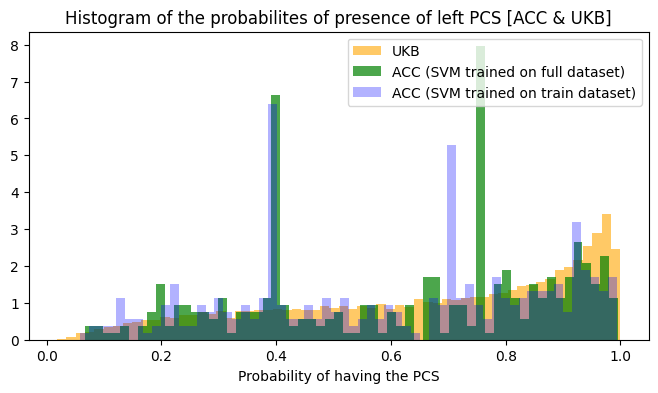

In [39]:
plt.figure(figsize=(8,4))
plt.hist(model.predict_proba(bdd_ukb)[:,1], bins=60, color='orange', alpha=0.6, label='UKB', density=True)
plt.hist(model.predict_proba(X)[:,1], bins=60, color='g', alpha=0.7, label='ACC (SVM trained on full dataset)', density=True)
plt.hist(model_train_test.predict_proba(X)[:,1], bins=60, color='b', alpha=0.3, label='ACC (SVM trained on train dataset)', density=True)
plt.xlabel('Probability of having the PCS')
plt.title('Histogram of the probabilites of presence of left PCS [ACC & UKB]')
plt.legend()
plt.savefig(f'{path_to_save}/histo_prob_left_PCS_ACC_UKB_left_PCS.eps', format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


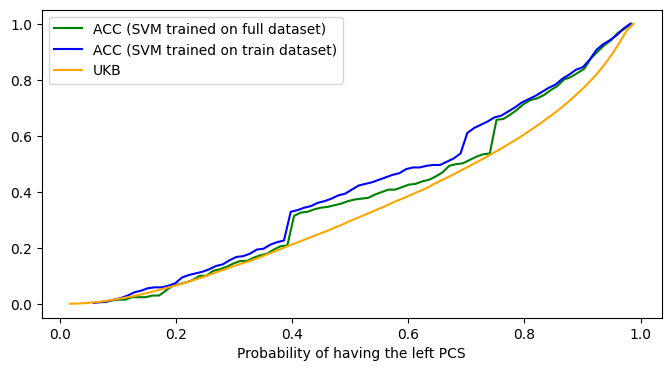

In [40]:
values_ACCP, base_ACCP = np.histogram(model.predict_proba(X)[:,1], bins=80)
cumulative_ACCP = np.cumsum(values_ACCP)

values_ACCP_train, base_ACCP_train = np.histogram(model_train_test.predict_proba(X)[:,1], bins=80)
cumulative_ACCP_train = np.cumsum(values_ACCP_train)

values_UKB, base_UKB = np.histogram(model.predict_proba(bdd_ukb)[:,1], bins=80)
cumulative_UKB = np.cumsum(values_UKB)


plt.figure(figsize=(8,4))
plt.plot(base_ACCP[:-1], cumulative_ACCP/len(X), c='g', label='ACC (SVM trained on full dataset)')
plt.plot(base_ACCP_train[:-1], cumulative_ACCP_train/len(X), c='b', label='ACC (SVM trained on train dataset)')
plt.plot(base_UKB[:-1], cumulative_UKB/len(bdd_ukb), c='orange', label='UKB')

plt.xlabel('Probability of having the left PCS')
plt.legend()
plt.savefig(f'{path_to_save}/cumulative_function_ACC_UKB_left_PCS.eps', format='eps')
plt.show()

In [33]:
ACC_pred = pd.DataFrame({"IID" : list(embeddings_ACCP.ID),
              "Left_Prob_Pred" : model.predict_proba(X)[:,1]})

print(ACC_pred.sort_values(by='Left_Prob_Pred').iloc[0:9])
print()
print(list(ACC_pred.sort_values(by='Left_Prob_Pred').iloc[0:9].IID))
print()
print(ACC_pred.sort_values(by='Left_Prob_Pred').iloc[-9:])
print()
print(list(ACC_pred.sort_values(by='Left_Prob_Pred').iloc[-9:].IID))

                                  IID  Left_Prob_Pred
94                       e0079_t1_s03        0.066597
230                  nih_chp_04910_t1        0.069782
87                       e0072_t1_s03        0.093215
164                  nih_chp_03812_t1        0.097505
80                  e0065_anat_t1_s03        0.107377
64                       e0039_t1_s03        0.125126
272                  nih_chp_05430_t1        0.129873
146                  nih_chp_02769_t1        0.131257
300  sub-active07_ses-pretraining_T1w        0.163222

['e0079_t1_s03', 'nih_chp_04910_t1', 'e0072_t1_s03', 'nih_chp_03812_t1', 'e0065_anat_t1_s03', 'e0039_t1_s03', 'nih_chp_05430_t1', 'nih_chp_02769_t1', 'sub-active07_ses-pretraining_T1w']

                                      IID  Left_Prob_Pred
135                      nih_chp_02221_t1        0.976598
333  sub-inhibition22_ses-pretraining_T1w        0.977927
4                            1-17COLMA_t0        0.980263
52                           a0034_t1_s0

In [55]:
HCP_pred = pd.DataFrame({"IID" : list(embeddings_HCP.index),
              "Left_Prob_Pred" : model.predict_proba(bdd_hcp)[:,1]})

print(HCP_pred.sort_values(by='Left_Prob_Pred').iloc[0:9])
print()
print(list(HCP_pred.sort_values(by='Left_Prob_Pred').iloc[0:9].IID))
print()
print(HCP_pred.sort_values(by='Left_Prob_Pred').iloc[-9:])
print()
print(list(HCP_pred.sort_values(by='Left_Prob_Pred').iloc[-9:].IID))

         IID  Left_Binary_Pred
742   461743          0.067706
735   448347          0.102681
428   183741          0.105387
393   176441          0.107944
917   700634          0.109685
1086  955465          0.110329
361   171330          0.113384
533   206727          0.118041
528   205725          0.121040

[461743, 448347, 183741, 176441, 700634, 955465, 171330, 206727, 205725]

         IID  Left_Binary_Pred
422   182032          0.992746
890   665254          0.992864
625   287248          0.993247
139   127933          0.993846
974   783462          0.994355
1080  942658          0.994512
538   207628          0.994595
1076  930449          0.996349
1090  962058          0.996642

[182032, 665254, 287248, 127933, 783462, 942658, 207628, 930449, 962058]


In [34]:
UKB_pred = pd.DataFrame({"IID" : list(embeddings_UKB.index),
              "Left_Prob_Pred" : model.predict_proba(bdd_ukb)[:,1]})

print(UKB_pred.sort_values(by='Left_Prob_Pred').iloc[0:9])
print()
print(list(UKB_pred.sort_values(by='Left_Prob_Pred').iloc[0:9].IID))
print()
print(UKB_pred.sort_values(by='Left_Prob_Pred').iloc[-9:])
print()
print(list(UKB_pred.sort_values(by='Left_Prob_Pred').iloc[-9:].IID))

               IID  Left_Prob_Pred
20813  sub-3469400        0.017629
19107  sub-3264612        0.018425
32182  sub-4805237        0.026051
3483   sub-1422413        0.027365
25109  sub-3969766        0.029073
103    sub-1016339        0.029806
22008  sub-3605675        0.031455
29479  sub-4491384        0.031628
16432  sub-2946274        0.031658

['sub-3469400', 'sub-3264612', 'sub-4805237', 'sub-1422413', 'sub-3969766', 'sub-1016339', 'sub-3605675', 'sub-4491384', 'sub-2946274']

               IID  Left_Prob_Pred
3469   sub-1421042        0.999985
7875   sub-1929601        0.999985
35202  sub-5169348        0.999985
35624  sub-5219963        0.999986
39244  sub-5653347        0.999986
34094  sub-5033389        0.999988
41606  sub-5926139        0.999989
9231   sub-2101658        0.999993
20335  sub-3411481        0.999994

['sub-1421042', 'sub-1929601', 'sub-5169348', 'sub-5219963', 'sub-5653347', 'sub-5033389', 'sub-5926139', 'sub-2101658', 'sub-3411481']


In [35]:
UKB_pred["IID"] = UKB_pred["IID"].apply(lambda x: int(x[4:]))
UKB_pred

,IID,Left_Prob_Pred
0,1000021,0.831404
1,1000325,0.951841
2,1000458,0.695218
3,1000575,0.319902
4,1000606,0.821020
...,...,...
42428,6023847,0.342923
42429,6024038,0.653594
42430,6024150,0.535647
42431,6024379,0.500000


In [36]:
UKB_pred.to_csv('/volatile/ad279118/Imaging_Genetics_2025/UKB_cingulate_pred/UKB_left_pred.csv', index=False)

### Visualization (UMAP)

We fit the reducer only on the UKB database (which is the largest), we concatenate the three bases and reduce them together.

In [201]:
scd_bdd_ACCP = pd.DataFrame(X,columns=embeddings_HCP.columns)

scd_bdd_hcp = pd.DataFrame(bdd_hcp, columns=embeddings_HCP.columns)

scd_bdd_UKB = pd.DataFrame(bdd_ukb, columns=embeddings_HCP.columns)


In [202]:
reducer = umap.UMAP()

reducer.fit(scd_bdd_UKB)

embedding2D_ACCP = reducer.transform(X)
embedding2D_HCP = reducer.transform(bdd_hcp)
embedding2D_UKB = reducer.transform(bdd_ukb)
                                    
embedding2D_ACCP = pd.DataFrame(embedding2D_ACCP,columns=['Dim 1', 'Dim 2'])
embedding2D_HCP = pd.DataFrame(embedding2D_HCP, columns=['Dim 1', 'Dim 2'])
embedding2D_UKB = pd.DataFrame(embedding2D_UKB, columns=['Dim 1', 'Dim 2'])



In [203]:
embedding2D_ACCP['Left_PCS'] = y.values
embedding2D_ACCP['Dataset'] = 'ACC'
embedding2D_ACCP['Prediction'] = model.predict(X)
embedding2D_ACCP['Pred_proba'] = model.predict_proba(X)[:,1]
embedding2D_ACCP['ID'] = ebdd_lbl_ACCP.index


embedding2D_HCP['Left_PCS'] = -1
embedding2D_HCP['Dataset'] = 'HCP'
embedding2D_HCP['Prediction'] = model.predict(bdd_hcp)
embedding2D_HCP['Pred_proba'] = model.predict_proba(bdd_hcp)[:,1]
embedding2D_HCP['ID'] = embeddings_HCP.index


embedding2D_UKB['Left_PCS'] = -1
embedding2D_UKB['Dataset'] = 'UKB'
embedding2D_UKB['Prediction'] = model.predict(bdd_ukb)
embedding2D_UKB['Pred_proba'] = model.predict_proba(bdd_ukb)[:,1]
embedding2D_UKB['ID'] = embeddings_UKB.index

HCP_and_ACCP_2D = pd.concat([embedding2D_ACCP, embedding2D_HCP], axis=0)
HCP_ACCP_UKB_2D = pd.concat([HCP_and_ACCP_2D, embedding2D_UKB], axis=0)

In [204]:
HCP_ACCP_UKB_2D.head()

,Dim 1,Dim 2,Left_PCS,Dataset,Prediction,Pred_proba,ID
0,4.015392,2.999133,0,ACC,0,0.242328,1-03HUBJO_t0
1,3.206913,3.755326,1,ACC,1,0.791800,1-08ANDTI_t0
2,3.084066,4.347035,1,ACC,0,0.170200,1-11LEBJO_t0
3,4.519847,8.278105,1,ACC,1,0.772334,1-15LEHMI_t0
4,4.997169,6.349745,1,ACC,1,0.988683,1-17COLMA_t0


### For 3D visualisation

In [47]:
reducer3D = umap.UMAP(n_components=3)

reducer3D.fit(scd_bdd_UKB)

embedding3D_ACCP = reducer3D.transform(X)
embedding3D_HCP = reducer3D.transform(bdd_hcp)
embedding3D_UKB = reducer3D.transform(bdd_ukb)
                                    
embedding3D_ACCP = pd.DataFrame(embedding3D_ACCP,columns=['Dim 1', 'Dim 2', 'Dim 3'])
embedding3D_HCP = pd.DataFrame(embedding3D_HCP, columns=['Dim 1', 'Dim 2', 'Dim 3'])
embedding3D_UKB = pd.DataFrame(embedding3D_UKB, columns=['Dim 1', 'Dim 2', 'Dim 3'])

In [48]:
embedding3D_ACCP['Left_PCS'] = y.values
embedding3D_ACCP['Dataset'] = 'ACC'
embedding3D_ACCP['Prediction'] = model.predict(X)
embedding3D_ACCP['Pred_proba'] = model.predict_proba(X)[:,1]
embedding3D_ACCP['ID'] = ebdd_lbl_ACCP.index


embedding3D_HCP['Left_PCS'] = -1
embedding3D_HCP['Dataset'] = 'HCP'
embedding3D_HCP['Prediction'] = model.predict(bdd_hcp)
embedding3D_HCP['Pred_proba'] = model.predict_proba(bdd_hcp)[:,1]
embedding3D_HCP['ID'] = embeddings_HCP.index


embedding3D_UKB['Left_PCS'] = -1
embedding3D_UKB['Dataset'] = 'UKB'
embedding3D_UKB['Prediction'] = model.predict(bdd_ukb)
embedding3D_UKB['Pred_proba'] = model.predict_proba(bdd_ukb)[:,1]
embedding3D_UKB['ID'] = embeddings_UKB.index

HCP_and_ACCP_3D = pd.concat([embedding3D_ACCP, embedding3D_HCP], axis=0)
HCP_ACCP_UKB_3D = pd.concat([HCP_and_ACCP_3D, embedding3D_UKB], axis=0)

In [49]:
print(len(embedding3D_ACCP), len(ebdd_lbl_ACCP.index))
print(len(embedding3D_HCP), len(embeddings_HCP.index))
print(len(embedding3D_UKB), len(embeddings_UKB.index))

341 341
1114 1114
21051 21051


In [65]:
HCP_and_ACCP_3D['Prediction'] = HCP_and_ACCP_3D['Prediction'].astype(str)
HCP_ACCP_UKB_3D['Prediction'] = HCP_ACCP_UKB_3D['Prediction'].astype(str)
HCP_ACCP_UKB_3D.head()

,Dim 1,Dim 2,Dim 3,Left_PCS,Dataset,Prediction,Pred_proba,ID
0,3.443465,3.313781,5.597828,0,ACCP,0,0.196307,1-03HUBJO_t0
1,3.056240,3.244252,3.328516,1,ACCP,1,0.797900,1-08ANDTI_t0
2,3.441321,5.335814,5.005774,1,ACCP,0,0.251095,1-11LEBJO_t0
3,4.946717,5.615586,5.430983,1,ACCP,1,0.774663,1-15LEHMI_t0
4,5.405264,6.249068,2.819029,1,ACCP,1,0.976432,1-17COLMA_t0


In [62]:
HCP_ACCP_UKB_3D.isna().sum(axis=0)

Dim 1         0
Dim 2         0
Dim 3         0
Left_PCS      0
Dataset       0
Prediction    0
Pred_proba    0
ID            0
dtype: int64

In [52]:
# https://plotly.com/python/pca-visualization/

import plotly.express as px

fig = px.scatter_3d(
    HCP_and_ACCP_3D, x='Dim 1', y='Dim 2', z='Dim 3', 
    color='Dataset',
    title=f'3D UMAP Dataset_HCP_ACCP',
    labels={'0': 'dim 1', '1': 'dim 2', '2': 'dim 3'},
    text='ID',
    opacity=0.7,
)
fig.update_traces(mode = 'markers')
fig.write_html("html_plot/Left_PCS_Dataset_HCP_ACCP.html")
fig.show()

In [66]:
fig = px.scatter_3d(
    HCP_and_ACCP_3D, x='Dim 1', y='Dim 2', z='Dim 3',
    color='Prediction',
    title=f'3D UMAP Prediction on HCP ACC',
    labels={'0': 'dim 1', '1': 'dim 2', '2': 'dim 3'},
    text='ID',
    opacity=0.7,
)
fig.update_traces(mode = 'markers')
fig.write_html("html_plot/Left_PCS_Prediction_HCP_ACCP.html")
fig.show()

In [55]:
fig = px.scatter_3d(
    HCP_and_ACCP_3D, x='Dim 1', y='Dim 2', z='Dim 3',
    color='Pred_proba',
    title=f'3D UMAP Proba prediction on HCP ACC',
    labels={'0': 'dim 1', '1': 'dim 2', '2': 'dim 3'},
    text='ID',
    opacity=0.7,
)
fig.update_traces(mode = 'markers')
fig.write_html("html_plot/Left_PCS_Proba_prediction_HCP_ACCP.html")

This first figure is made to observe the site effect between UKB, ACCP and HCP databases. 

In [205]:
def plot_UMAP(dataset, title, hue):

    ebb2D_dataset = dataset[['Dim 1', 'Dim 2']]
    unique_values = np.sort(dataset[hue].unique())

    if type(dataset[hue].iloc[0])==type("str"):
        unique_colors = [sns.color_palette()[i] for i in range(len(unique_values))]
        dataset_colors = [sns.color_palette()[0] if x == 'HCP'\
                          else sns.color_palette()[1] if x == 'ACC' \
                          else sns.color_palette()[2] for x in dataset['Dataset']]
        s = [8 if x == 'HCP'\
            else 8 if x == 'ACC' \
            else 0.3 for x in dataset['Dataset']]
    elif -1 in unique_values :
        unique_values[:-1], unique_values[-1] = unique_values[1:], unique_values[0] 
        unique_colors = [sns.color_palette()[i] for i in range(len(unique_values))]
        dataset_colors = [sns.color_palette()[x] if x!=-1 else sns.color_palette()[len(unique_values)-1] for x in dataset[hue]]
        s = 10
    else :
        unique_colors = [sns.color_palette()[i] for i in range(len(unique_values))]
        dataset_colors = [sns.color_palette()[x] for x in dataset[hue]]
        s = 20

    plt.figure(figsize=(12,8))
    plt.scatter(
        ebb2D_dataset.iloc[:, 0],
        ebb2D_dataset.iloc[:, 1],
        s=s,
        c=dataset_colors)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(title, fontsize=12)
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor=unique_colors[i], markersize=10, 
                                label=f'{unique_values[i]}') 
                    for i in range(len(unique_values))]
    plt.legend(handles=legend_handles, title=hue, loc='best')
    plt.show()

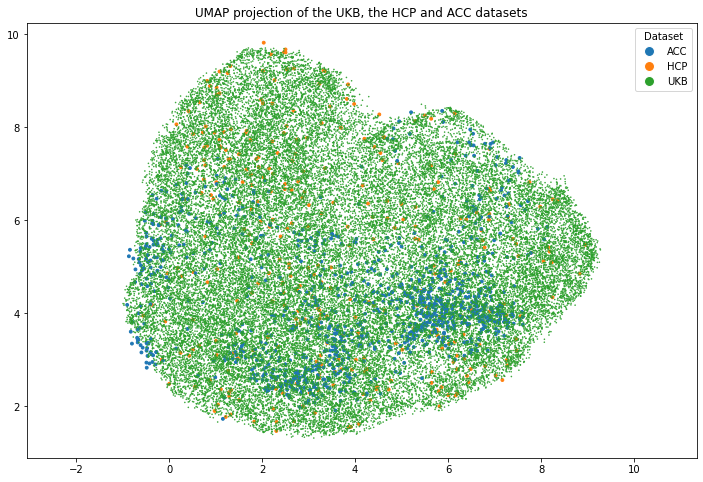

In [206]:
plot_UMAP(HCP_ACCP_UKB_2D, 'UMAP projection of the UKB, the HCP and ACC datasets', 'Dataset')

The second figure is made to point out the position of the people having the paracingular (1) (from the ACCP database), those who don't have it (0) (from the ACCP database), and those we don't know (-1) (from the HCP database).

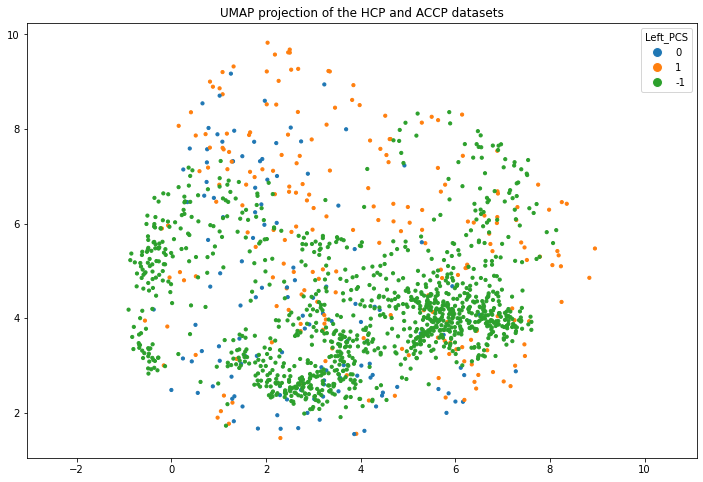

In [207]:
plot_UMAP(HCP_and_ACCP_2D, 'UMAP projection of the HCP and ACCP datasets', 'Left_PCS')

Then, the following figure highlights the two classes in the ACCP database.

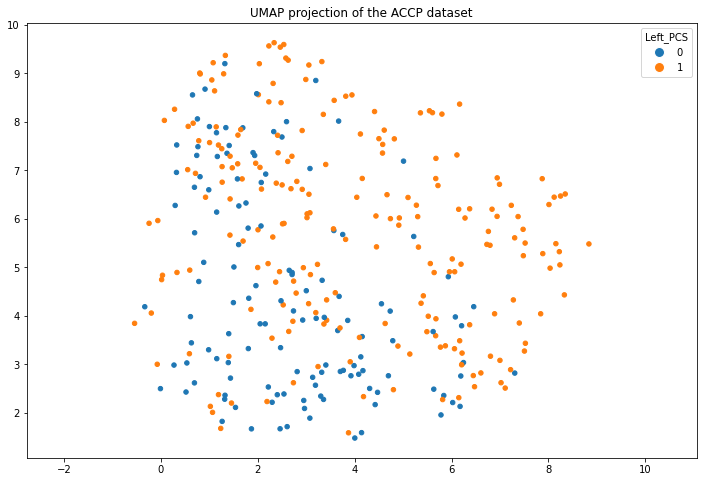

In [208]:
embedding2D_ACCP = reducer.transform(scd_bdd_ACCP)
embedding2D_ACCP = pd.DataFrame(embedding2D_ACCP,columns=['Dim 1', 'Dim 2'])
embedding2D_ACCP['Left_PCS'] = y.values
embedding2D_ACCP['Dataset'] = 'ACC'
embedding2D_ACCP['Prediction'] = model.predict(X)
embedding2D_ACCP['Pred_proba'] = model.predict_proba(X)[:,1]
embedding2D_ACCP['ID'] = ebdd_lbl_ACCP.index
plot_UMAP(embedding2D_ACCP, 'UMAP projection of the ACCP dataset', 'Left_PCS')

Let's see the SVC borders on the UMAP

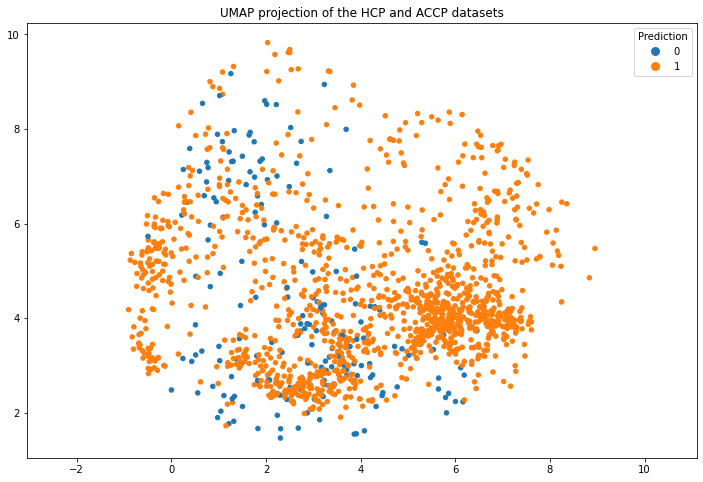

In [209]:
plot_UMAP(HCP_and_ACCP_2D, 'UMAP projection of the HCP and ACCP datasets', 'Prediction')

### CSV file generation for SOLAR

In [ ]:
df_HCP_binary_pred_PCS = pd.DataFrame({"IID" : list(embeddings_HCP.index),
              "Pred" : model.predict(X=bdd_hcp)})

#df_HCP_binary_pred_PCS.to_csv('/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Heritability/data/HCP_binary_pred_left_PCS_2.csv', index=False)
df_HCP_binary_pred_PCS.sort_values('IID')

,IID,Pred
0,100206,0
1,100307,1
2,100408,0
3,100610,0
4,101006,0
...,...,...
1109,992774,0
1110,993675,1
1111,994273,0
1112,995174,0


In [ ]:
df_HCP_prob_pred_PCS = pd.DataFrame({"IID" : list(embeddings_HCP.index),
              "Pred" : model.predict_proba(bdd_hcp)[:,1]})

#df_HCP_prob_pred_PCS.to_csv('/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Heritability/data/HCP_prob_pred_left_PCS_2.csv', index=False)
df_HCP_prob_pred_PCS

,IID,Pred
0,100206,0.328975
1,100307,0.705047
2,100408,0.600544
3,100610,0.416104
4,101006,0.258237
...,...,...
1109,992774,0.537250
1110,993675,0.707631
1111,994273,0.343621
1112,995174,0.584266


### To compare the prediction obtained from different embeddings models (dim256)

In [ ]:
left_PCS_pred2_dim256 = pd.read_csv('/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Heritability/data/HCP_prob_pred_left_PCS_2.csv')
left_PCS_pred_dim256 = pd.read_csv('/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Heritability/data/HCP_prob_pred_left_PCS.csv')
LeftPCS = pd.merge(left_PCS_pred_dim256, left_PCS_pred2_dim256, how='inner', on='IID', suffixes=[2561,2562])
LeftPCS.drop('IID', axis=1).corr()

,Pred2561,Pred2562
Pred2561,1.000000,0.949155
Pred2562,0.949155,1.000000


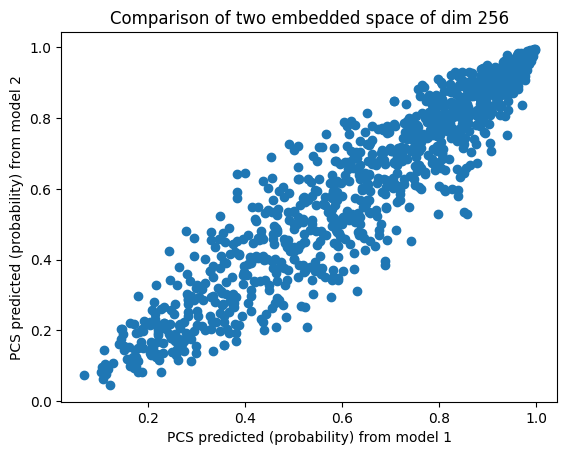

In [ ]:
plt.scatter(LeftPCS['Pred2561'], LeftPCS['Pred2562'])
plt.xlabel('PCS predicted (probability) from model 1')
plt.ylabel('PCS predicted (probability) from model 2')
plt.title('Comparison of two embedded space of dim 256')
plt.show()

In [ ]:
left_PCS_pred_dim2561 = pd.read_csv('/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Heritability/data/HCP_binary_pred_left_PCS.csv')
left_PCS_pred_dim2562 = pd.read_csv('/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Heritability/data/HCP_binary_pred_left_PCS_2.csv')

In [ ]:
(left_PCS_pred_dim2561['Pred'] == left_PCS_pred_dim2562['Pred']).sum()/len(left_PCS_pred_dim2561)

0.9111310592459605